# Disease and Conflict Analysis

This notebook adds explicit variables for post-conflict periods and unforeseen pandemic-like shocks (including COVID-era years), then evaluates whether they improve life expectancy prediction.

## New variables introduced
- `conflict_shock_proxy`: proxy for conflict-like disruption
- `post_conflict_5y_proxy`: years 1-5 after a conflict-like shock
- `covid_era_dummy`: indicator for 2020-2021
- `pandemic_stress_scenario` variables for stress-testing predictions


## 1) Imports and Paths

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

sns.set_theme(style='whitegrid')
RANDOM_STATE = 42
TARGET = 'life_expectancy'

# Robust path resolution (works from repo root or Codes/)
CWD = Path.cwd().resolve()
if (CWD / 'Assets' / 'cleaner_exports').exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / 'Assets' / 'cleaner_exports').exists():
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

DATA_DIR = PROJECT_ROOT / 'Assets' / 'cleaner_exports'
FULL_PATH = DATA_DIR / 'health_panel_ml_numeric.csv'

if not FULL_PATH.exists():
    raise FileNotFoundError(f'Missing file: {FULL_PATH.resolve()}')

print('Project root:', PROJECT_ROOT)
print('Data dir    :', DATA_DIR)

Project root: /Users/bikki/Documents/Projects_Spring_2026/STATS201
Data dir    : /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports


## 2) Load Data

In [2]:
full_df = pd.read_csv(FULL_PATH)

# 70-30 temporal split by years (first 70% years for train, last 30% years for test)
years = sorted(full_df['Year'].dropna().astype(int).unique().tolist())
n_years = len(years)
train_n = max(1, int(np.floor(0.70 * n_years)))
train_years = years[:train_n]
test_years = years[train_n:]

if len(test_years) == 0:
    raise ValueError('Test years are empty. Check Year coverage before splitting.')

train_df = full_df[full_df['Year'].isin(train_years)].copy()
test_df = full_df[full_df['Year'].isin(test_years)].copy()

train_ratio = len(train_df) / len(full_df)
test_ratio = len(test_df) / len(full_df)

print('Train:', train_df.shape, '| years', min(train_years), '-', max(train_years))
print('Test :', test_df.shape, '| years', min(test_years), '-', max(test_years))
print('Full :', full_df.shape)
print(f'Row split ratio -> train: {train_ratio:.3f}, test: {test_ratio:.3f}')

Train: (3456, 19) | years 2000 - 2017
Test : (768, 19) | years 2018 - 2021
Full : (4224, 19)


## 3) Engineer Conflict and Pandemic Variables

### Conflict proxies
Because there is no direct conflict dataset column, we build a conservative proxy from abrupt deterioration in socioeconomic/health-system conditions:
- large annual increase in `underweight_adults_pct`
- or large annual decrease in `gdp_per_capita_2015usd`

A country-year that crosses threshold is marked `conflict_shock_proxy = 1`.
Then `post_conflict_5y_proxy = 1` for the next five years.

### Pandemic proxies
- `covid_era_dummy = 1` for years >= 2020
- `pandemic_stress_proxy = 1` when immunization coverage drops sharply year-over-year


In [3]:
def fit_country_thresholds(panel: pd.DataFrame):
    t = panel.sort_values(['Country', 'Year']).copy()
    t['d_underweight'] = t.groupby('Country')['underweight_adults_pct'].diff()
    t['d_gdp'] = t.groupby('Country')['gdp_per_capita_2015usd'].diff()
    t['d_dtp3'] = t.groupby('Country')['dtp3_coverage_pct'].diff()

    thresholds = {}
    for c, g in t.groupby('Country'):
        uw = g['d_underweight'].dropna()
        dg = g['d_gdp'].dropna()
        d3 = g['d_dtp3'].dropna()

        uw_thr = np.nanquantile(uw, 0.90) if len(uw) else 2.0
        gdp_thr = np.nanquantile(dg, 0.10) if len(dg) else -200.0
        dtp_thr = np.nanquantile(d3, 0.10) if len(d3) else -3.0

        thresholds[c] = {
            'uw_thr': float(max(1.5, uw_thr)),
            'gdp_thr': float(min(-100.0, gdp_thr)),
            'dtp_thr': float(min(-2.0, dtp_thr)),
        }
    return thresholds


def add_conflict_pandemic_features(panel: pd.DataFrame, thresholds: dict, post_years: int = 5):
    out = panel.sort_values(['Country', 'Year']).copy()

    out['d_underweight'] = out.groupby('Country')['underweight_adults_pct'].diff()
    out['d_gdp'] = out.groupby('Country')['gdp_per_capita_2015usd'].diff()
    out['d_dtp3'] = out.groupby('Country')['dtp3_coverage_pct'].diff()

    out['conflict_shock_proxy'] = 0
    out['post_conflict_5y_proxy'] = 0
    out['covid_era_dummy'] = (out['Year'] >= 2020).astype(int)
    out['pandemic_stress_proxy'] = 0

    for c, grp in out.groupby('Country', sort=False):
        idx = grp.index.to_list()
        thr = thresholds.get(c, {'uw_thr': 2.0, 'gdp_thr': -200.0, 'dtp_thr': -3.0})

        shock = ((grp['d_underweight'] >= thr['uw_thr']) | (grp['d_gdp'] <= thr['gdp_thr'])).fillna(False).astype(int).to_numpy()
        pshock = (grp['d_dtp3'] <= thr['dtp_thr']).fillna(False).astype(int).to_numpy()

        post = np.zeros(len(grp), dtype=int)
        for i in range(len(grp)):
            lo = max(0, i - post_years)
            if shock[lo:i].sum() > 0:
                post[i] = 1

        out.loc[idx, 'conflict_shock_proxy'] = shock
        out.loc[idx, 'post_conflict_5y_proxy'] = post
        out.loc[idx, 'pandemic_stress_proxy'] = pshock

    return out


thresholds = fit_country_thresholds(train_df)
full_aug = add_conflict_pandemic_features(full_df, thresholds)

add_cols = ['Country', 'Year', 'conflict_shock_proxy', 'post_conflict_5y_proxy', 'covid_era_dummy', 'pandemic_stress_proxy']
train_df = train_df.merge(full_aug[add_cols], on=['Country', 'Year'], how='left')
test_df = test_df.merge(full_aug[add_cols], on=['Country', 'Year'], how='left')

for c in add_cols[2:]:
    train_df[c] = train_df[c].fillna(0)
    test_df[c] = test_df[c].fillna(0)

print('Train means for added vars:')
print(train_df[add_cols[2:]].mean().round(4))
print('\nTest means for added vars:')
print(test_df[add_cols[2:]].mean().round(4))


Train means for added vars:
conflict_shock_proxy      0.0573
post_conflict_5y_proxy    0.1997
covid_era_dummy           0.0000
pandemic_stress_proxy     0.1042
dtype: float64

Test means for added vars:
conflict_shock_proxy      0.1719
post_conflict_5y_proxy    0.2604
covid_era_dummy           0.5000
pandemic_stress_proxy     0.1901
dtype: float64


## 4) Feature Sets and Model Evaluation

In [4]:
base_features = [
    'adult_mortality_15_60',
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'log_infant_deaths',
    'u5_mortality_rate',
]

conflict_disease_features = base_features + [
    'conflict_shock_proxy',
    'post_conflict_5y_proxy',
    'covid_era_dummy',
    'pandemic_stress_proxy',
]


def evaluate(feature_cols, model):
    X_train = train_df[feature_cols].copy()
    X_test = test_df[feature_cols].copy()
    y_train = train_df[TARGET].to_numpy()
    y_test = test_df[TARGET].to_numpy()

    pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('scl', StandardScaler()),
        ('mdl', model),
    ])
    pipe.fit(X_train, y_train)

    yhat_train = pipe.predict(X_train)
    yhat_test = pipe.predict(X_test)

    return {
        'pipeline': pipe,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'Train_R2': r2_score(y_train, yhat_train),
        'Test_R2': r2_score(y_test, yhat_test),
        'Train_RMSE': float(np.sqrt(mean_squared_error(y_train, yhat_train))),
        'Test_RMSE': float(np.sqrt(mean_squared_error(y_test, yhat_test))),
        'Train_MAE': mean_absolute_error(y_train, yhat_train),
        'Test_MAE': mean_absolute_error(y_test, yhat_test),
    }


model_zoo = {
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Random Forest (300,15)': RandomForestRegressor(n_estimators=300, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting (200,3)': GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=RANDOM_STATE),
    'Linear Regression': LinearRegression(),
}

rows = []
artifacts = {}
for name, model in model_zoo.items():
    b = evaluate(base_features, model)
    c = evaluate(conflict_disease_features, model)

    rows.append({'Model': name, 'Feature_Set': 'base', 'N_Features': len(base_features), 'Train_R2': b['Train_R2'], 'Test_R2': b['Test_R2'], 'Train_RMSE': b['Train_RMSE'], 'Test_RMSE': b['Test_RMSE'], 'Train_MAE': b['Train_MAE'], 'Test_MAE': b['Test_MAE']})
    rows.append({'Model': name, 'Feature_Set': 'disease_conflict_augmented', 'N_Features': len(conflict_disease_features), 'Train_R2': c['Train_R2'], 'Test_R2': c['Test_R2'], 'Train_RMSE': c['Train_RMSE'], 'Test_RMSE': c['Test_RMSE'], 'Train_MAE': c['Train_MAE'], 'Test_MAE': c['Test_MAE']})

    artifacts[(name, 'base')] = b
    artifacts[(name, 'disease_conflict_augmented')] = c

results_df = pd.DataFrame(rows)
results_df['Delta_Test_R2_vs_base'] = results_df.groupby('Model')['Test_R2'].transform(lambda s: s - s.iloc[0])
results_df['Delta_Test_RMSE_vs_base'] = results_df.groupby('Model')['Test_RMSE'].transform(lambda s: s - s.iloc[0])
results_df.sort_values(['Model', 'Feature_Set'])


,Model,Feature_Set,N_Features,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Delta_Test_R2_vs_base,Delta_Test_RMSE_vs_base
4,"Gradient Boosting (200,3)",base,12,0.996581,0.984841,0.502604,0.865054,0.385418,0.631908,0.000000,0.000000
5,"Gradient Boosting (200,3)",disease_conflict_augmented,16,0.996486,0.984593,0.509541,0.872103,0.388737,0.640132,-0.000248,0.007049
6,Linear Regression,base,12,0.980118,0.969918,1.211983,1.218607,0.895277,0.967309,0.000000,0.000000
7,Linear Regression,disease_conflict_augmented,16,0.980166,0.969391,1.210500,1.229223,0.893823,0.974360,-0.000526,0.010616
2,"Random Forest (300,15)",base,12,0.999694,0.988479,0.150385,0.754141,0.103960,0.521731,0.000000,0.000000
3,"Random Forest (300,15)",disease_conflict_augmented,16,0.999701,0.988436,0.148585,0.755550,0.104138,0.523978,-0.000043,0.001409
0,Ridge (alpha=1.0),base,12,0.980117,0.969912,1.211986,1.218729,0.895276,0.967298,0.000000,0.000000
1,Ridge (alpha=1.0),disease_conflict_augmented,16,0.980166,0.969384,1.210503,1.229358,0.893818,0.974385,-0.000527,0.010629


## 5) Graph: Base vs Augmented Performance

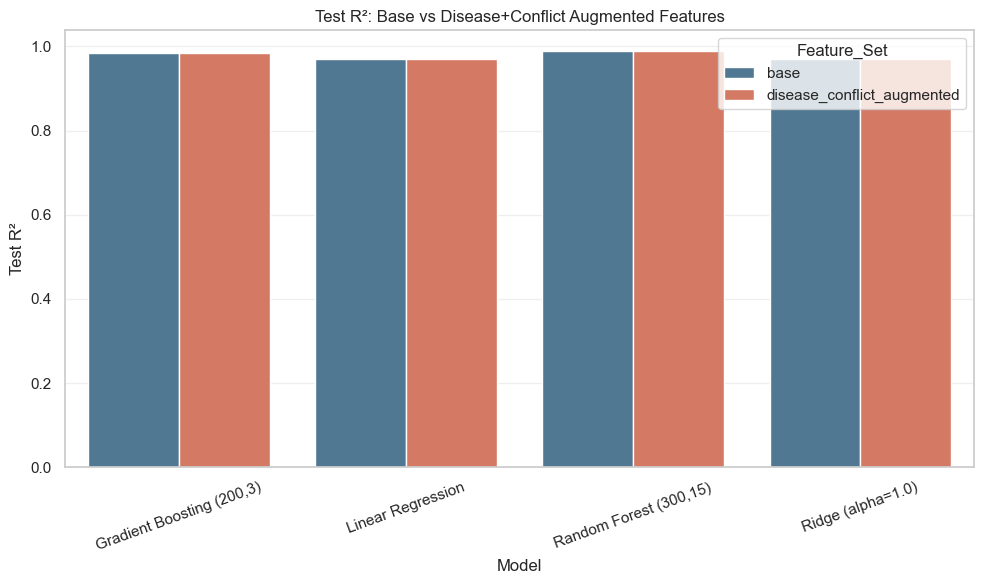

In [5]:
plot_df = results_df.copy()
plot_df = plot_df.sort_values(['Model', 'Feature_Set'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_df, x='Model', y='Test_R2', hue='Feature_Set', ax=ax, palette=['#457b9d', '#e76f51'])
ax.set_title('Test R²: Base vs Disease+Conflict Augmented Features')
ax.set_ylabel('Test R²')
ax.set_xlabel('Model')
ax.tick_params(axis='x', rotation=20)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 6) Variable Weightage in Best Augmented Model

In [6]:
best_aug = results_df[results_df['Feature_Set'] == 'disease_conflict_augmented'].sort_values(['Test_R2', 'Test_RMSE'], ascending=[False, True]).iloc[0]
key = (best_aug['Model'], 'disease_conflict_augmented')
art = artifacts[key]

pi = permutation_importance(
    art['pipeline'],
    art['X_test'],
    art['y_test'],
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring='r2'
)

imp_df = pd.DataFrame({'Feature': conflict_disease_features, 'Importance': pi.importances_mean})
imp_df = imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)
imp_df['Weight_%'] = 100 * imp_df['Importance'] / imp_df['Importance'].sum()

print('Best augmented model:', best_aug['Model'])
print('Test R²:', round(best_aug['Test_R2'], 4), '| Test RMSE:', round(best_aug['Test_RMSE'], 4))
imp_df.head(15)


Best augmented model: Random Forest (300,15)
Test R²: 0.9884 | Test RMSE: 0.7556


,Feature,Importance,Weight_%
0,adult_mortality_15_60,1.131657,85.295060
1,u5_mortality_rate,0.173051,13.043162
2,log_gdp_per_capita_2015usd,0.007290,0.549461
3,thinness_children_adolescents_pct,0.005691,0.428927
4,alcohol_per_capita_15plus,0.004434,0.334236
5,log_infant_deaths,0.001714,0.129189
6,overweight_adults_pct,0.001166,0.087866
7,underweight_adults_pct,0.000767,0.057825
8,che_pct_gdp,0.000514,0.038715
9,dtp3_coverage_pct,0.000191,0.014411


## 7) Graph: Importance of Added Disease/Conflict Variables

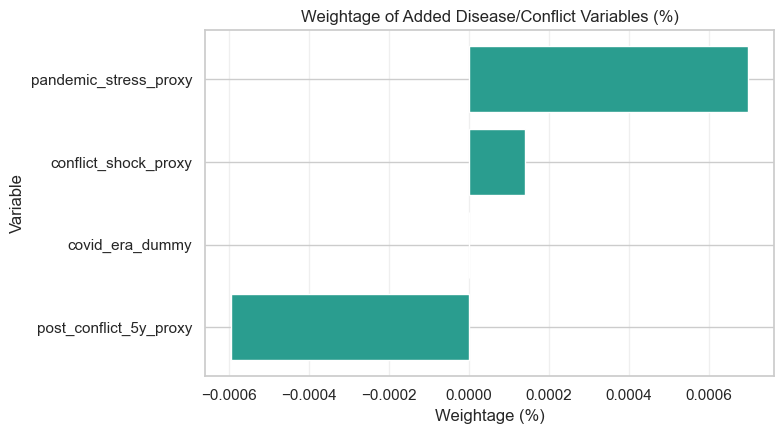

In [7]:
added_vars = ['conflict_shock_proxy', 'post_conflict_5y_proxy', 'covid_era_dummy', 'pandemic_stress_proxy']
added_imp = imp_df[imp_df['Feature'].isin(added_vars)].copy().sort_values('Weight_%', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.barh(added_imp['Feature'], added_imp['Weight_%'], color='#2a9d8f')
ax.set_title('Weightage of Added Disease/Conflict Variables (%)')
ax.set_xlabel('Weightage (%)')
ax.set_ylabel('Variable')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 8) Unforeseen Scenario Stress Test (Pandemic Shock)

In [8]:
# Stress test on test period: simulate stronger pandemic disruption
stress = art['X_test'].copy()

# Shock assumptions for unforeseen outbreak severity
stress['dtp3_coverage_pct'] = np.clip(stress['dtp3_coverage_pct'] - 8.0, 0, 100)
stress['pol3_coverage_pct'] = np.clip(stress['pol3_coverage_pct'] - 8.0, 0, 100)
stress['hepb3_coverage_pct'] = np.clip(stress['hepb3_coverage_pct'] - 8.0, 0, 100)
stress['che_pct_gdp'] = np.clip(stress['che_pct_gdp'] - 1.0, 0, None)
stress['pandemic_stress_proxy'] = 1
stress['covid_era_dummy'] = 1

baseline_pred = art['pipeline'].predict(art['X_test'])
stress_pred = art['pipeline'].predict(stress)

delta = stress_pred - baseline_pred

summary = pd.DataFrame({
    'Scenario': ['Baseline test period', 'Pandemic-stress scenario'],
    'Mean_Predicted_Life_Expectancy': [baseline_pred.mean(), stress_pred.mean()]
})

print(summary)
print('\nAverage change (stress - baseline):', round(delta.mean(), 3), 'years')
print('Median change :', round(np.median(delta), 3), 'years')
print('P10 / P90 change:', round(np.percentile(delta,10),3), '/', round(np.percentile(delta,90),3), 'years')


                   Scenario  Mean_Predicted_Life_Expectancy
0      Baseline test period                       72.058587
1  Pandemic-stress scenario                       72.035512

Average change (stress - baseline): -0.023 years
Median change : -0.015 years
P10 / P90 change: -0.134 / 0.066 years


## 9) Graph: Distribution Shift Under Pandemic Stress

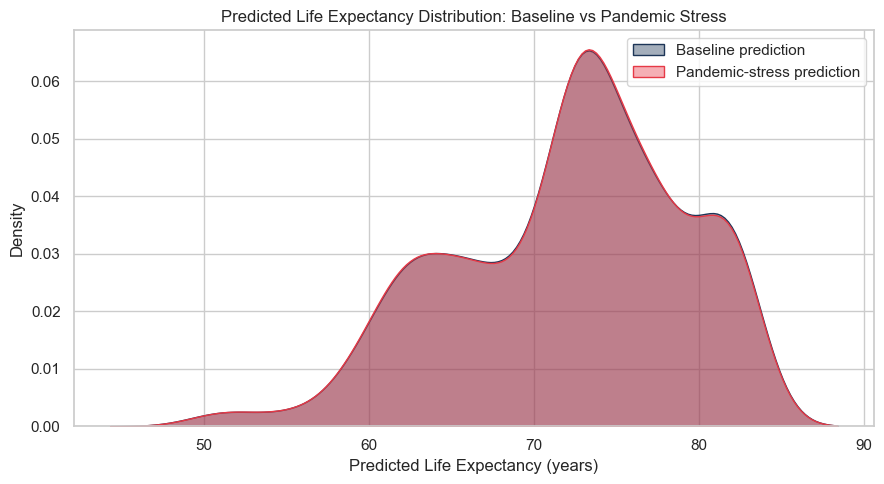

In [9]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.kdeplot(baseline_pred, fill=True, alpha=0.4, label='Baseline prediction', ax=ax, color='#1d3557')
sns.kdeplot(stress_pred, fill=True, alpha=0.4, label='Pandemic-stress prediction', ax=ax, color='#e63946')
ax.set_title('Predicted Life Expectancy Distribution: Baseline vs Pandemic Stress')
ax.set_xlabel('Predicted Life Expectancy (years)')
ax.set_ylabel('Density')
ax.legend()
plt.tight_layout()
plt.show()


## 10) Summary

- Added conflict and pandemic proxies, including explicit COVID-era indicator years (`covid_era_dummy`).
- Compared each model with and without these variables.
- Reported variable weightage using permutation importance for the best augmented model.
- Ran an unforeseen pandemic stress scenario showing expected downward shift in predicted life expectancy under sharper immunization and health-system shocks.

These proxies are scenario-analysis features, not ground-truth conflict/pandemic labels; they should be interpreted as approximate risk signals.
